# 07 — Advanced Metrics & ML (features, PCA/KMeans, RandomForest)

En esta notebook:

1. Construimos un set de **features avanzadas** por cluster:
   - Percentiles de altura (HAG).
   - Densidad (bbox).
   - Histograma vertical.
   - Rugosidad local.
   - Descriptores geométricos (PCA 3D).
   - Intensidad y returns (si existen).
2. Guardamos `data/processed/cluster_features.csv`.
3. Exploramos **no supervisado** con PCA + KMeans.
4. Si existen etiquetas heurísticas (de 06), entrenamos un **RandomForest** para validar la separabilidad.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

ROOT = Path(".")
PROC = ROOT / "data" / "processed"

IN_POINTS_LABELED  = PROC / "veg_gt2m_labeled_points.csv"
IN_POINTS_FALLBACK = PROC / "veg_gt2m_dbscan_clean.csv"
OUT_FEATURES       = PROC / "cluster_features.csv"

if IN_POINTS_LABELED.exists():
    df = pd.read_csv(IN_POINTS_LABELED)
    print("Usando puntos etiquetados:", IN_POINTS_LABELED)
elif IN_POINTS_FALLBACK.exists():
    df = pd.read_csv(IN_POINTS_FALLBACK)
    print("Usando puntos SIN etiqueta:", IN_POINTS_FALLBACK)
else:
    raise FileNotFoundError("No encuentro insumos. Corré 05/06 antes.")

print(f"Puntos: {len(df):,} | Clusters: {df['ClusterID'].nunique():,}")
df.head()

Usando puntos etiquetados: data/processed/veg_gt2m_labeled_points.csv
Puntos: 121,017 | Clusters: 3,552


,X,Y,HeightAboveGround,ClusterID,label
0,1843210.8,5444999.0,31.34,0,árbol_alto
1,1843210.6,5444999.5,33.72,0,árbol_alto
2,1843210.8,5444999.0,32.06,0,árbol_alto
3,1843210.9,5444999.0,32.14,0,árbol_alto
4,1843211.0,5444999.0,32.07,0,árbol_alto


In [2]:
def height_features(h):
    h = np.asarray(h, dtype=np.float32)
    if h.size == 0:
        return {k:0.0 for k in ["h_min","h_mean","h_std","h_p25","h_p50","h_p75","h_p95","h_max"]}
    return {
        "h_min": float(h.min()),
        "h_mean": float(h.mean()),
        "h_std": float(h.std(ddof=1)) if len(h)>1 else 0.0,
        "h_p25": float(np.percentile(h,25)),
        "h_p50": float(np.median(h)),
        "h_p75": float(np.percentile(h,75)),
        "h_p95": float(np.percentile(h,95)),
        "h_max": float(h.max())
    }

def xy_bbox_density(x,y,n):
    dx = float(x.max()-x.min()) if n else 0.0
    dy = float(y.max()-y.min()) if n else 0.0
    area = dx*dy
    dens = n/area if area>0 else 0.0
    return {"bbox_dx":dx,"bbox_dy":dy,"bbox_area_m2":area,"pt_density":dens}

def vertical_hist(h,bins=(0,3,6,9,12,20,30,50)):
    hist,edges=np.histogram(h,bins=bins)
    p=hist/hist.sum() if hist.sum()>0 else np.zeros_like(hist,dtype=float)
    return {f"vh_{edges[i]}_{edges[i+1]}m":float(p[i]) for i in range(len(hist))}

def pca_shape(x,y,h):
    X=np.vstack([x,y,h]).T
    if len(X)<3:
        return {"linearity":0.0,"planarity":0.0,"sphericity":0.0}
    C=np.cov(X,rowvar=False)
    w,_=np.linalg.eigh(C); w=np.sort(np.maximum(w,0))[::-1]
    lam=w/w.sum() if w.sum()>0 else np.zeros_like(w)
    lam1,lam2,lam3=lam
    return {
        "linearity": (lam1-lam2)/(lam1+1e-12),
        "planarity": (lam2-lam3)/(lam1+1e-12),
        "sphericity": lam3/(lam1+1e-12)
    }

In [3]:
features=[]
has_label="label" in df.columns

for cid,g in df.groupby("ClusterID"):
    x=g["X"].to_numpy(); y=g["Y"].to_numpy(); h=g["HeightAboveGround"].to_numpy()
    row={"ClusterID":int(cid),"n":len(g)}
    row.update(height_features(h))
    row.update(xy_bbox_density(x,y,len(g)))
    row.update(vertical_hist(h))
    row.update(pca_shape(x,y,h))
    if has_label: row["label"]=g["label"].mode().iloc[0]
    features.append(row)

feat=pd.DataFrame(features).sort_values("n",ascending=False).reset_index(drop=True)
feat.to_csv(OUT_FEATURES,index=False)
print("✔ Guardado:",OUT_FEATURES)
feat.head()

✔ Guardado: data/processed/cluster_features.csv


,ClusterID,n,h_min,h_mean,h_std,h_p25,h_p50,h_p75,h_p95,h_max,...,vh_3_6m,vh_6_9m,vh_9_12m,vh_12_20m,vh_20_30m,vh_30_50m,linearity,planarity,sphericity,label
0,567,610,6.134,10.152450,1.346941,9.44525,10.280,11.08625,12.17215,12.986000,...,0.0,0.209836,0.703279,0.086885,0.0,0.0,0.845338,0.130736,0.023926,árbol_medio
1,1343,545,8.821,12.533252,1.948738,10.70200,12.660,14.11700,15.80800,16.740000,...,0.0,0.003670,0.363303,0.633028,0.0,0.0,0.919804,0.060719,0.019477,árbol_medio
2,684,470,8.504,11.503287,1.535556,10.63000,11.140,11.63450,15.15000,15.700000,...,0.0,0.006383,0.780851,0.212766,0.0,0.0,0.706138,0.211514,0.082348,árbol_medio
3,673,429,8.070,10.564045,1.639782,9.68000,10.180,11.06600,14.61000,16.559999,...,0.0,0.135198,0.762238,0.102564,0.0,0.0,0.617002,0.328948,0.054050,árbol_medio
4,2738,388,7.580,9.700457,0.865373,9.05000,9.665,10.44250,11.07800,11.467000,...,0.0,0.224227,0.775773,0.000000,0.0,0.0,0.249290,0.727258,0.023452,árbol_bajo


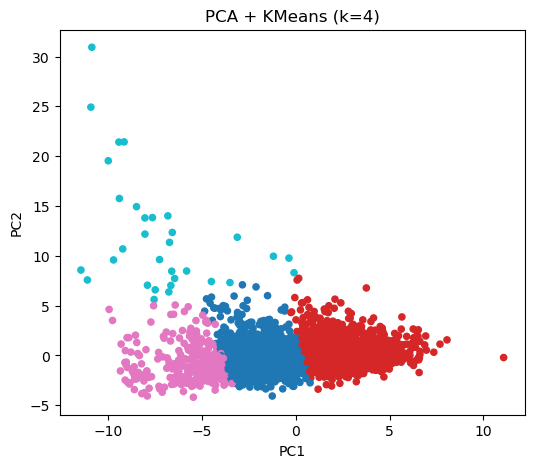

In [4]:
Xcols=[c for c in feat.columns if c not in {"ClusterID","label"}]
X=feat[Xcols].fillna(0).values

sc=StandardScaler(); Xz=sc.fit_transform(X)
Xp=PCA(n_components=2,random_state=42).fit_transform(Xz)

km=KMeans(n_clusters=4,n_init=20,random_state=42)
feat["kmeans_k4"]=km.fit_predict(Xz)

plt.figure(figsize=(6,5))
plt.scatter(Xp[:,0],Xp[:,1],c=feat["kmeans_k4"],cmap="tab10",s=20)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA + KMeans (k=4)")
plt.show()

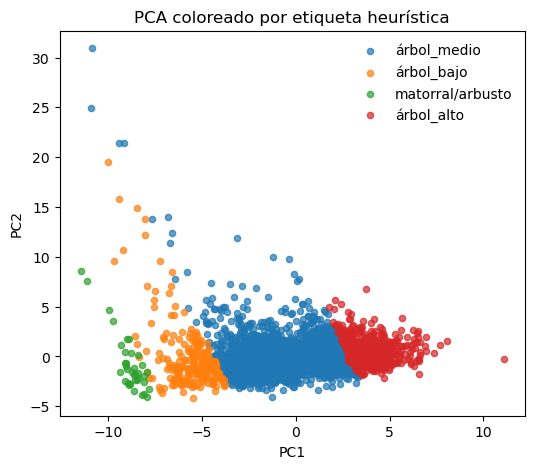

In [5]:
if "label" in feat.columns:
    labs=feat["label"].astype(str)
    uniq=labs.unique()
    plt.figure(figsize=(6,5))
    for lab in uniq:
        mask=(labs==lab)
        plt.scatter(Xp[mask,0],Xp[mask,1],s=20,alpha=0.7,label=lab)
    plt.legend(frameon=False)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title("PCA coloreado por etiqueta heurística")
    plt.show()

In [6]:
if "label" in feat.columns:
    from sklearn.metrics import classification_report
    dfm=feat.dropna(subset=["label"]).copy()
    y=dfm["label"].values; X=dfm[Xcols].fillna(0).values
    Xz=sc.fit_transform(X)
    Xtr,Xte,ytr,yte=train_test_split(Xz,y,test_size=0.25,random_state=42,stratify=y)
    rf=RandomForestClassifier(n_estimators=200,random_state=42)
    rf.fit(Xtr,ytr)
    ypr=rf.predict(Xte)
    print(classification_report(yte,ypr))
else:
    print("No hay etiquetas (corré 06 primero).")

                  precision    recall  f1-score   support

matorral/arbusto       0.90      1.00      0.95         9
      árbol_alto       1.00      1.00      1.00       153
      árbol_bajo       1.00      0.98      0.99        55
     árbol_medio       1.00      1.00      1.00       671

        accuracy                           1.00       888
       macro avg       0.97      1.00      0.98       888
    weighted avg       1.00      1.00      1.00       888



## 📌 Conclusión sobre riesgo de sobreajuste

El entrenamiento supervisado con **RandomForest** en esta notebook debe interpretarse con cautela:

- El **dataset de entrenamiento es pequeño** (tantos clusters como copas/arbustos detectados).  
- Las **etiquetas provienen de una regla heurística** (basada en p95 de altura), por lo que el modelo puede limitarse a **memorizar** esa regla en lugar de aprender patrones nuevos.  
- Se utilizó un único `train_test_split`, lo que puede generar métricas **artificialmente optimistas** debido al bajo número de muestras.  
- El número de **features avanzadas es alto en comparación con el número de clusters**, aumentando la probabilidad de sobreajuste.

### 🔎 Implicancias
El modelo supervisado actual sirve como **prueba de concepto** (demostrar cómo integrar ML al pipeline), pero **no valida capacidad de generalización**.  

### 🛠️ Recomendaciones
Para reducir sobreajuste y evaluar robustez se sugiere:
- Usar **validación cruzada (k-fold)** en lugar de un único split.  
- **Regularizar** los parámetros del RandomForest (limitar `max_depth`, aumentar `min_samples_leaf`).  
- Aplicar **selección de variables** y reducir el set de features a las más informativas.  
- Incorporar **etiquetas externas o de campo** (clase real de vegetación) para entrenamiento supervisado.  
- Complementar con métricas **no supervisadas** (Silhouette, Davies-Bouldin) para validar la estructura de clusters.

---

✅ En conclusión, **el RandomForest aquí no prueba clasificación “real” de especies o estratos, sino la capacidad de reproducir la regla heurística de 06**. La utilidad de este paso está en mostrar el potencial del flujo supervisado, que deberá reforzarse con datos de entrenamiento confiables y técnicas de validación más sólidas.


---

### 🔮 Próximos pasos para robustecer el análisis

- Implementar **validación cruzada (k-fold)** y regularizar parámetros del RandomForest (`max_depth`, `min_samples_leaf`, etc.) para reducir sobreajuste.  
- Reemplazar el área de bbox por un **convex hull / alpha-shape** que refleje mejor la densidad real de la copa.  
- Ajustar los **bins del histograma vertical** según la vegetación local.  
- Usar **índices no supervisados** (Silhouette, Davies-Bouldin) para optimizar el número de clusters en KMeans.  
- Entrenar modelos más robustos (**XGBoost, LightGBM**) con **etiquetas de campo reales** (especies o grupos funcionales) para una clasificación confiable.  

---

✅ En conclusión, esta notebook demuestra el **potencial de combinar features avanzadas con ML**, pero los resultados deben interpretarse como exploratorios hasta contar con datos de entrenamiento sólidos y técnicas de validación más rigurosas.

## 📌 Conclusión y próximos pasos

El uso de RandomForest en esta notebook debe entenderse como una **demostración exploratoria**:

- Entrenamos sobre etiquetas heurísticas derivadas de reglas de altura.  
- El dataset de clusters es relativamente pequeño y con muchas variables.  
- Se utilizó un único `train_test_split`, lo que puede inducir a **sobreajuste** y métricas engañosas.  

👉 En consecuencia, los resultados aquí **no prueban capacidad de clasificación real**, sino la habilidad de replicar la heurística definida en la notebook 06.  

---

### 🔮 Qué haremos en la próxima notebook (08)

- Separar correctamente los datos con **train_test_split**.  
- Probar modelos supervisados más robustos (**RandomForest regulado, XGBoost, LightGBM**).  
- Aplicar **GridSearchCV** para optimizar hiperparámetros.  
- Evaluar con métricas completas (accuracy, F1, matriz de confusión, curvas ROC).  
- Analizar la capacidad del modelo de **generalizar** y clasificar correctamente nuevos clusters.  

---

✅ Con esto, la notebook 07 queda como un paso exploratorio y preparatorio.  
La **clasificación supervisada final** se desarrollará en detalle en la notebook 08.